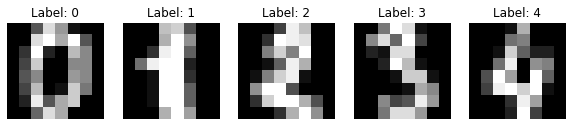

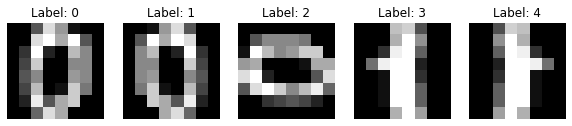

Cross-Validation Scores: [0.98347826 0.98347826 0.97304348 0.97913043 0.97826087]
Test Accuracy (Best Model): 0.980528511821975
Test Accuracy (Bagging Model): 0.9756606397774688
Test Accuracy (Voting Model): 0.9735744089012517


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

# Load the digit dataset
digits = load_digits()
images = digits.images
labels = digits.target

# Data augmentation (optional)
def augment_data(images, labels):
    augmented_images = []
    augmented_labels = []
    for image, label in zip(images, labels):
        augmented_images.append(image)
        augmented_labels.append(label)

        augmented_images.append(np.fliplr(image))
        augmented_labels.append(label)

        augmented_images.append(np.rot90(image, k=1))
        augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

augmented_images, augmented_labels = augment_data(images, labels)

# Combine original and augmented data
all_images = np.concatenate([images, augmented_images])
all_labels = np.concatenate([labels, augmented_labels])

# Visualize the original images and their augmented counterparts
def plot_images(images, labels, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.show()

num_samples = 5  # Number of samples to visualize for each category
original_images_sample = images[:num_samples]
augmented_images_sample = augmented_images[:num_samples]

plot_images(original_images_sample, labels[:num_samples], 1, num_samples)
plot_images(augmented_images_sample, labels[:num_samples], 1, num_samples)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Model Selection and Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
}

rf_model = RandomForestClassifier()
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train.reshape(len(X_train), -1), y_train)
best_model = grid_search.best_estimator_

# Cross-Validation
cross_val_scores = cross_val_score(best_model, X_train.reshape(len(X_train), -1), y_train, cv=5)

# Regularization (adjusting max_depth)
regularized_model = RandomForestClassifier(max_depth=10)  # You can adjust max_depth here
regularized_model.fit(X_train.reshape(len(X_train), -1), y_train)

# Ensemble Techniques (Bagging and Voting)
bagging_model = BaggingClassifier(base_estimator=regularized_model, n_estimators=10, random_state=42)
voting_model = VotingClassifier([('rf', regularized_model), ('bagging', bagging_model)])

# Train the Bagging and Voting models on the entire training data
bagging_model.fit(X_train.reshape(len(X_train), -1), y_train)
voting_model.fit(X_train.reshape(len(X_train), -1), y_train)

# Evaluate the Bagging and Voting models on the test set
y_pred_bagging = bagging_model.predict(X_test.reshape(len(X_test), -1))
y_pred_voting = voting_model.predict(X_test.reshape(len(X_test), -1))

test_accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
test_accuracy_voting = accuracy_score(y_test, y_pred_voting)

# Print results
print("Cross-Validation Scores:", cross_val_scores)
print("Test Accuracy (Best Model):", best_model.score(X_test.reshape(len(X_test), -1), y_test))
print("Test Accuracy (Bagging Model):", test_accuracy_bagging)
print("Test Accuracy (Voting Model):", test_accuracy_voting)
